In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [106]:
from sklearn.preprocessing import LabelEncoder

In [107]:
from sklearn.preprocessing import StandardScaler

In [108]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [109]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [110]:
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [111]:
# 2 заимствованных метода
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('report.png')
    plt.show()
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [112]:
data = reduce_mem_usage(pd.read_csv("train.csv"))

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 0.0%


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in longlong_scalars


# Просмотрим основную информацию о данных

In [113]:
data.head(30)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [114]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049957,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685265,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506104,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284721,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066681,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689711,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int16
MSSubClass       1460 non-null int16
MSZoning         1460 non-null category
LotFrontage      1201 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null category
Alley            91 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null category
RoofMatl         1460 non-null category

# Обработаем пропуски

In [116]:
mode_lf=data['LotFrontage'].mode()[0]
data['LotFrontage'].fillna(value=mode_lf, inplace=True)
mode_mv=data['MasVnrArea'].mode()[0]
data['MasVnrArea'].fillna(value=mode_mv, inplace=True)
mode_mv=data['GarageYrBlt'].mode()[0]
data['GarageYrBlt'].fillna(value=mode_mv, inplace=True)
mode_mv=data['GarageQual'].mode()[0]
data['GarageQual'].fillna(value=mode_mv, inplace=True)
mode_mv=data['GarageCond'].mode()[0]
data['GarageCond'].fillna(value=mode_mv, inplace=True)
mode_mv=data['GarageFinish'].mode()[0]
data['GarageFinish'].fillna(value=mode_mv, inplace=True)
mode_mv=data['GarageType'].mode()[0]
data['GarageType'].fillna(value=mode_mv, inplace=True)


In [117]:
mode_mv=data['MasVnrType'].mode()[0]
data['MasVnrType'].fillna(value=mode_mv, inplace=True)
mode_mv=data['MasVnrArea'].mode()[0]
data['MasVnrArea'].fillna(value=mode_mv, inplace=True)
mode_mv=data['BsmtQual'].mode()[0]
data['BsmtQual'].fillna(value=mode_mv, inplace=True)
mode_mv=data['BsmtExposure'].mode()[0]
data['BsmtExposure'].fillna(value=mode_mv, inplace=True)
mode_mv=data['BsmtFinType1'].mode()[0]
data['BsmtFinType1'].fillna(value=mode_mv, inplace=True)
mode_mv=data['BsmtFinType2'].mode()[0]
data['BsmtFinType2'].fillna(value=mode_mv, inplace=True)
mode_mv=data['Electrical'].mode()[0]
data['Electrical'].fillna(value=mode_mv, inplace=True)

In [118]:
mode_mv=data['BsmtCond'].mode()[0]
data['BsmtCond'].fillna(value=mode_mv, inplace=True)

### Столбцы, где очень мало значений, сохраняем в отдельный датасет, и удаляем из основного

In [119]:
for_drop=['Alley', 'FireplaceQu', 'PoolQC', 'Fence','MiscFeature' ]
extra_columns = data[for_drop].copy()
extra_columns

,Alley,FireplaceQu,PoolQC,Fence,MiscFeature
0,NaN,NaN,NaN,NaN,NaN
1,NaN,TA,NaN,NaN,NaN
2,NaN,TA,NaN,NaN,NaN
3,NaN,Gd,NaN,NaN,NaN
4,NaN,TA,NaN,NaN,NaN
5,NaN,NaN,NaN,MnPrv,Shed
6,NaN,Gd,NaN,NaN,NaN
7,NaN,TA,NaN,NaN,Shed
8,NaN,TA,NaN,NaN,NaN
9,NaN,TA,NaN,NaN,NaN


In [120]:
data.drop(for_drop, inplace=True, axis=1)

In [121]:
data.drop('Id', inplace=True, axis=1)

# Выделяем числовые признаки, категориальные, отделяем целевую переменную

In [122]:
obj_data_names=data.select_dtypes(include='category').columns.tolist()
len(obj_data_names)

38

In [123]:
target=data['SalePrice']
target

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int32

In [124]:
data.drop('SalePrice', inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
MSSubClass       1460 non-null int16
MSZoning         1460 non-null category
LotFrontage      1460 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null category
RoofMatl         1460 non-null category
Exterior1st      1460 non-null category
Exterior2nd      1460 non-null cat

In [125]:
num_data_names=data.select_dtypes(exclude='category').columns.tolist()
len(num_data_names)

36

# Построим матрицу корреляций и графики

In [126]:
data.shape

(1460, 74)

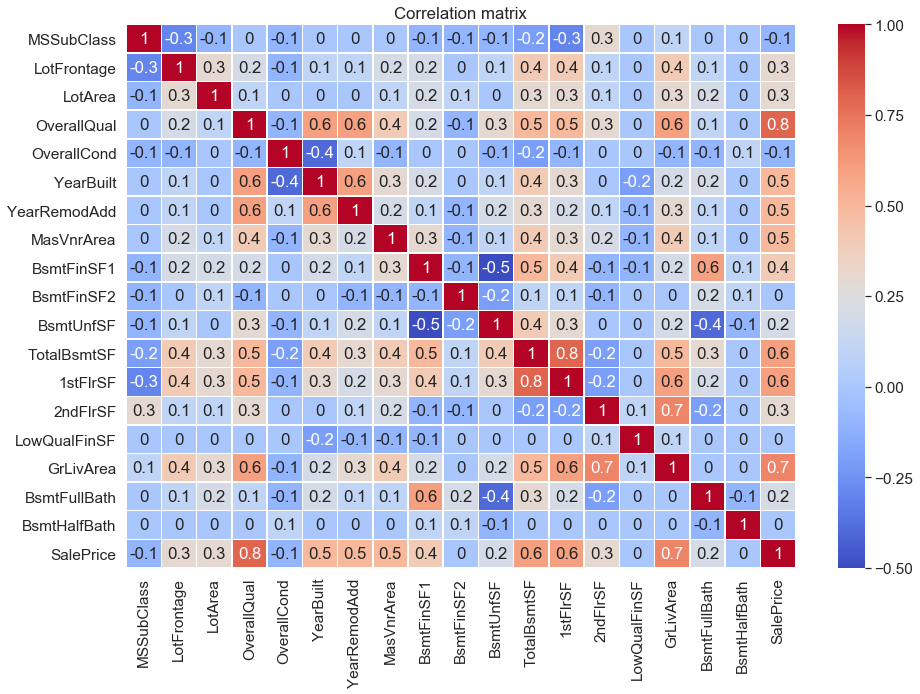

In [127]:
df_1=data[num_data_names[:18]].copy()
df_1['SalePrice']=target

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_1.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix.shape

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()



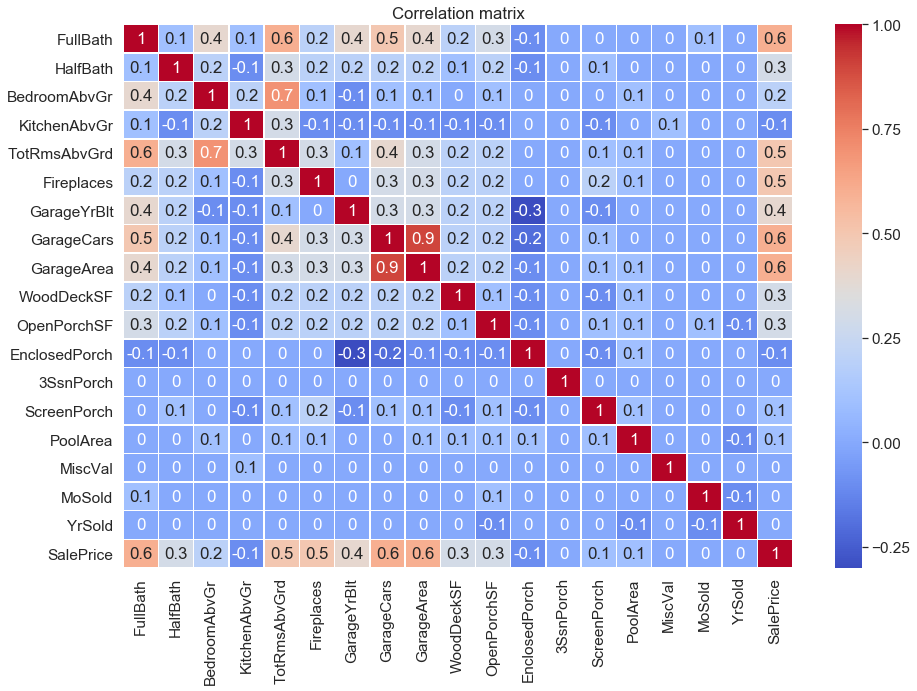

In [128]:
df_2=data[num_data_names[18:]].copy()
df_2['SalePrice']=target

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_2.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix.shape

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


In [129]:
len(num_data_names)

36

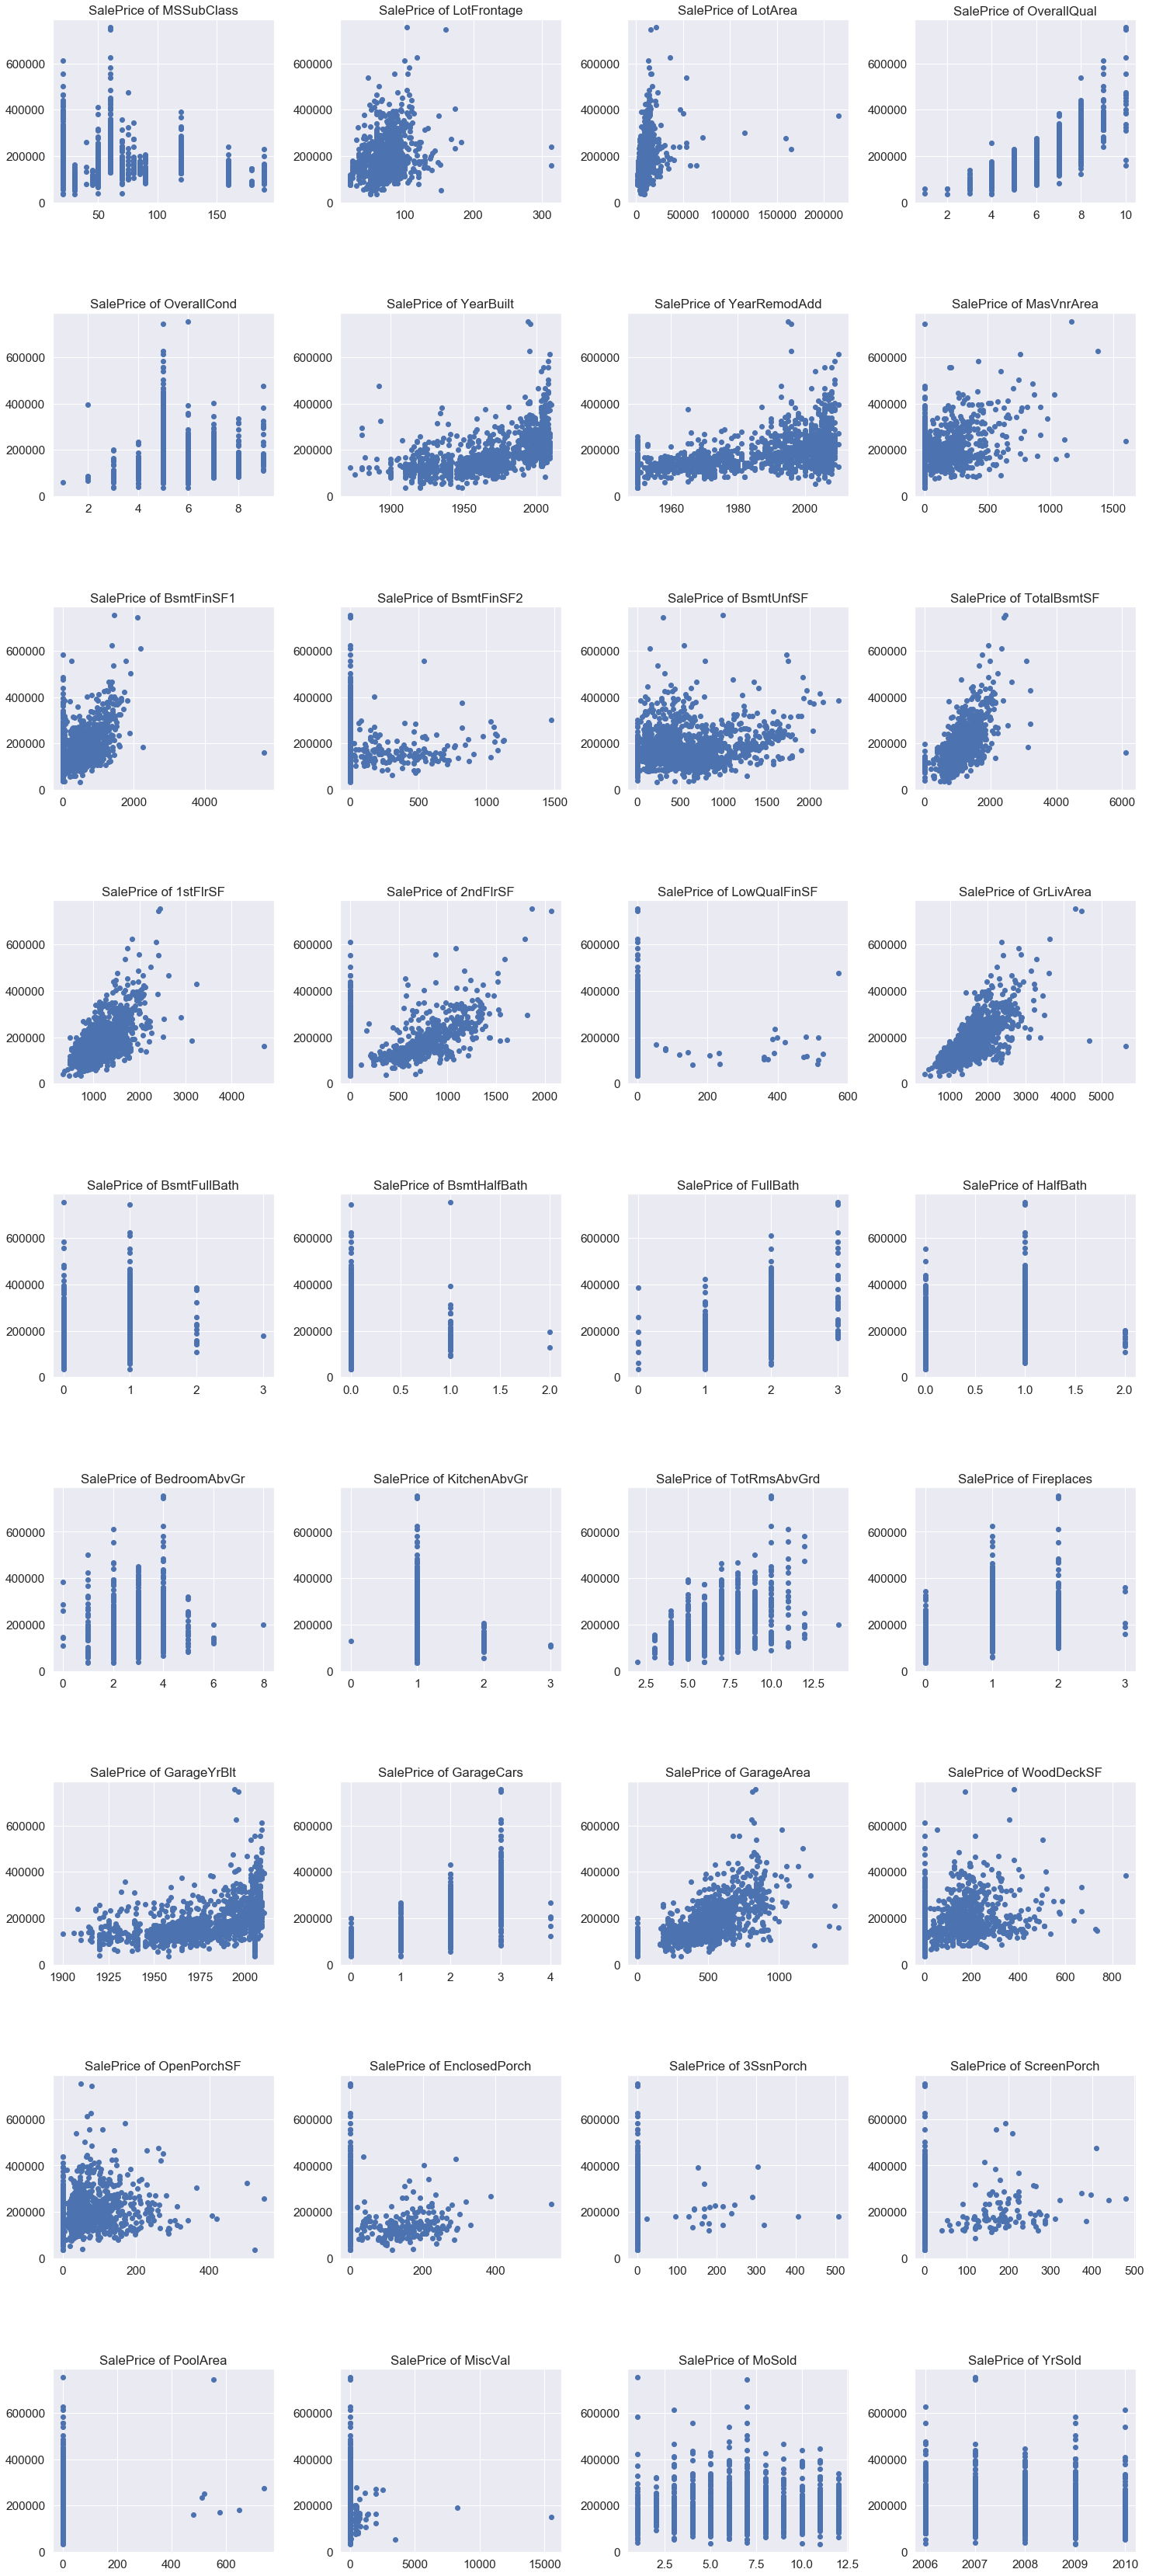

In [136]:
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(25, 60))
fig.subplots_adjust(wspace=0.3, hspace=0.6)

n=len(num_data_names)
count=0
for row in range(9):
    for j in range(4):
        axes[row,j].scatter(data[num_data_names[count]], target)
        axes[row,j].set_title("SalePrice of "+num_data_names[count])
        count+=1
        


# Переведем категориальные признаки в числовые

In [137]:
labelencoder = LabelEncoder()
for o in obj_data_names:
    data[o] = labelencoder.fit_transform(data[o])
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
MSSubClass       1460 non-null int16
MSZoning         1460 non-null int32
LotFrontage      1460 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null int32
LotShape         1460 non-null int32
LandContour      1460 non-null int32
Utilities        1460 non-null int32
LotConfig        1460 non-null int32
LandSlope        1460 non-null int32
Neighborhood     1460 non-null int32
Condition1       1460 non-null int32
Condition2       1460 non-null int32
BldgType         1460 non-null int32
HouseStyle       1460 non-null int32
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null int32
RoofMatl         1460 non-null int32
Exterior1st      1460 non-null int32
Exterior2nd      1460 non-null int32
MasVnrType       1460 non-null int32
MasVn

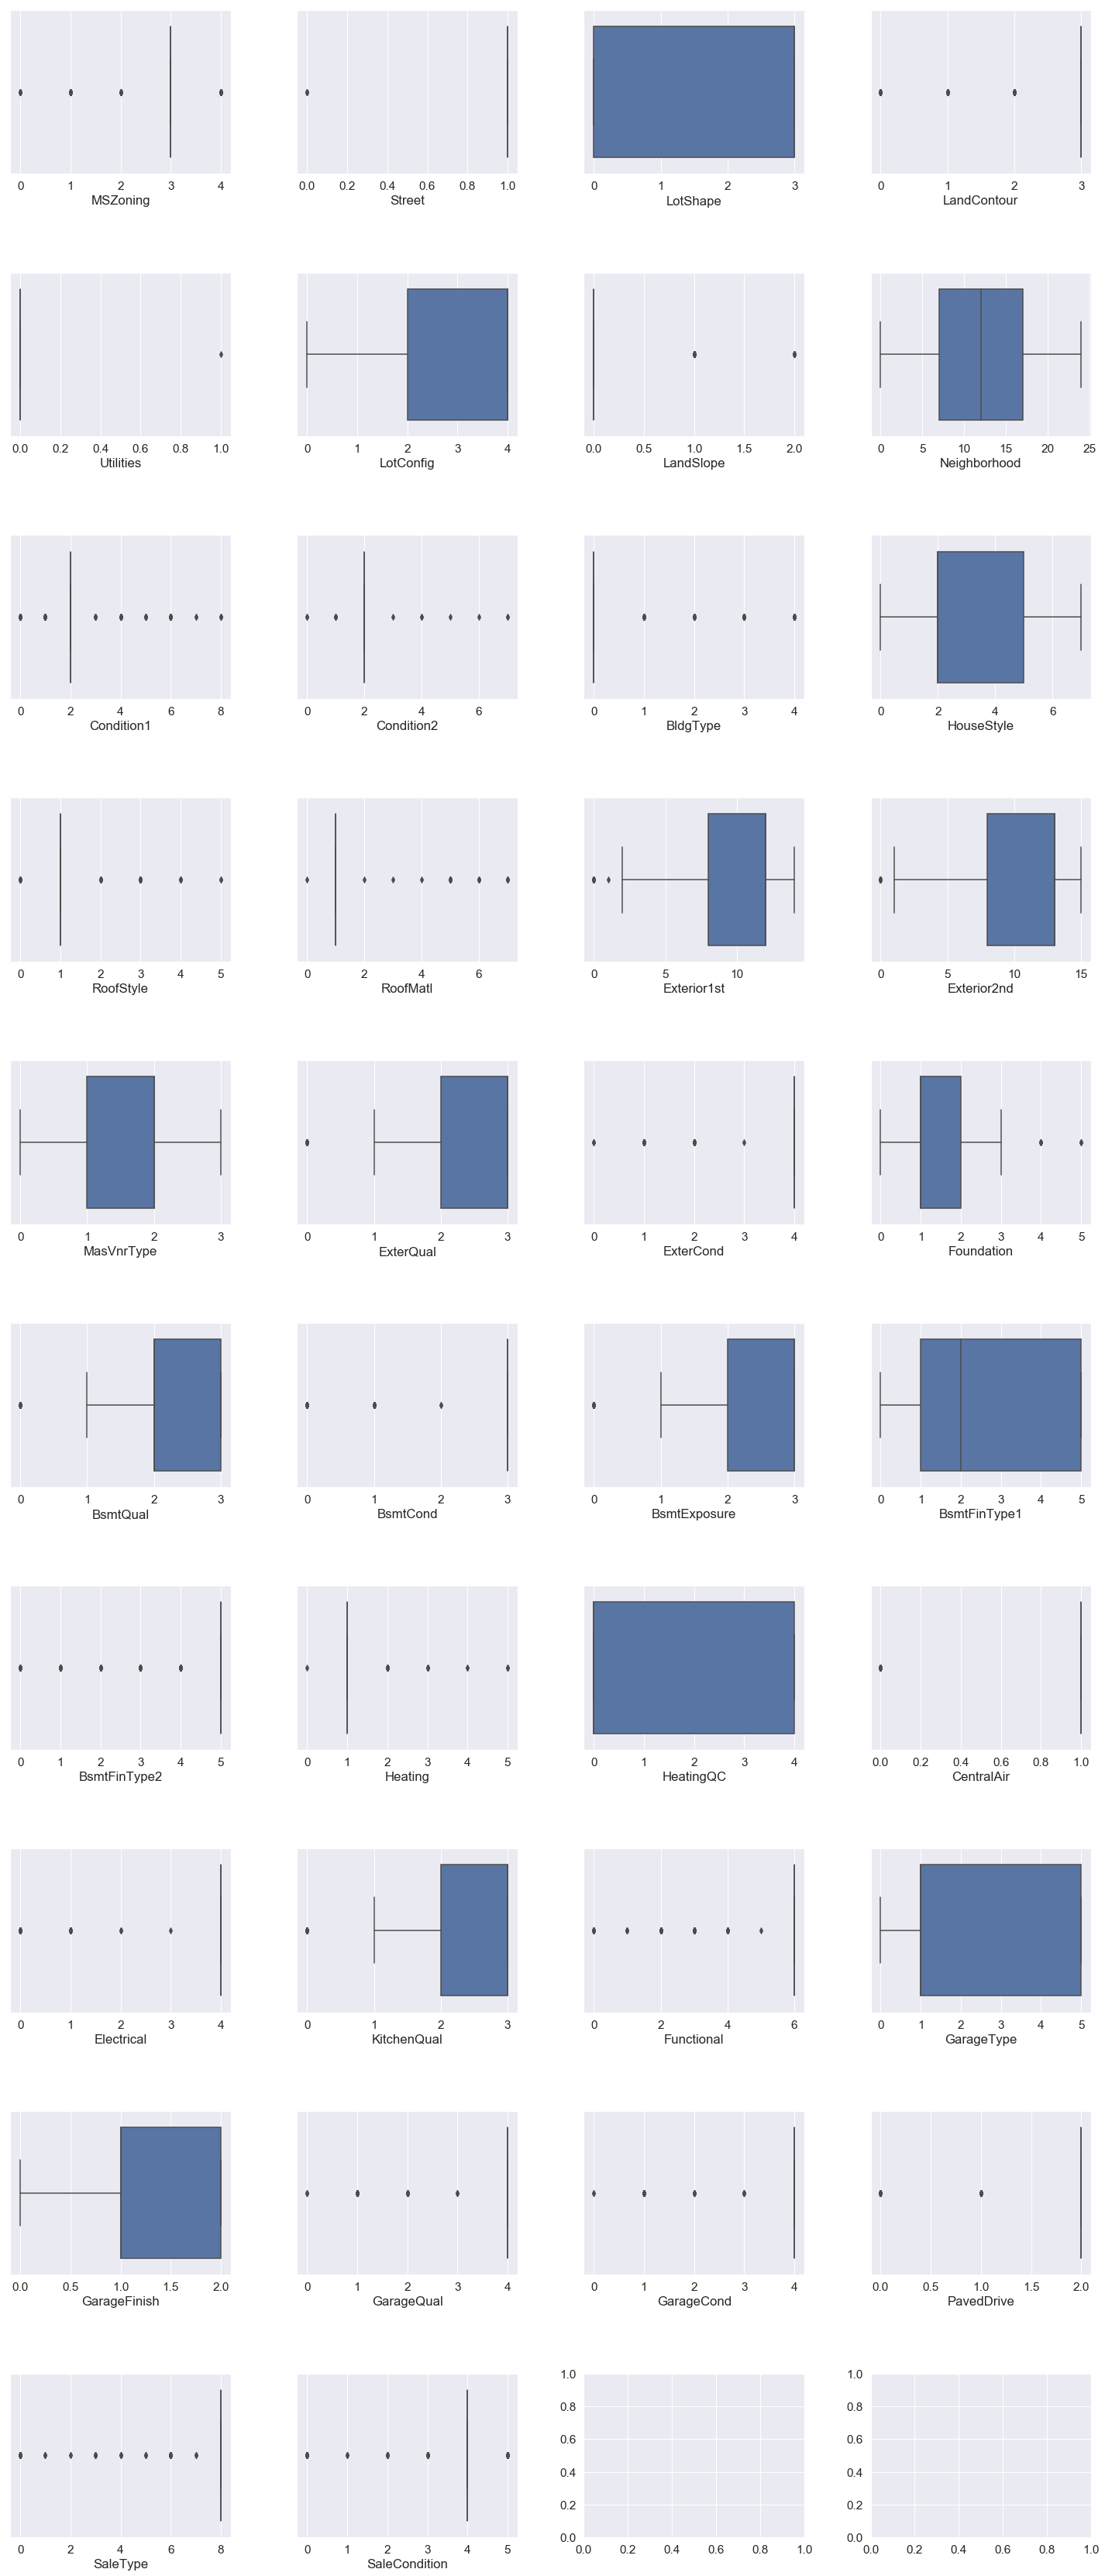

In [138]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(25, 60))
fig.subplots_adjust(wspace=0.3, hspace=0.6)

n=len(obj_data_names)
count=0
for row in range(10):
    for j in range(4):
        if count < n:
            sns.boxplot(x=data[obj_data_names[count]], ax=axes[row,j])
            count+=1

In [139]:
pd.set_option('display.max_columns', None)
data.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,3.028767,68.267120,10516.828082,0.995890,1.942466,2.777397,0.000685,3.019178,0.062329,12.251370,2.031507,2.008219,0.493151,3.038356,6.099315,5.575342,1971.267808,1984.865753,1.410274,1.075342,9.624658,10.339726,1.762329,103.117126,2.539726,3.733562,1.396575,2.280137,2.817123,2.284247,2.789726,443.639726,4.715753,46.549315,567.240411,1057.429452,1.036301,1.538356,0.934932,3.682192,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,2.339726,6.517808,5.749315,0.613014,2.208219,1979.976074,1.228767,1.767123,472.980137,3.871918,3.905479,1.856164,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,7.513014,3.770548
std,42.300571,0.632017,22.356401,9981.264932,0.063996,1.409156,0.707666,0.026171,1.622634,0.276232,6.013735,0.868515,0.259040,1.198277,1.911305,1.382997,1.112799,30.202904,20.645407,0.834998,0.599127,3.197659,3.540570,0.614274,180.731125,0.693995,0.731807,0.722394,0.864510,0.650919,1.138472,1.837550,456.098091,0.925252,161.319273,441.866955,438.705324,0.295124,1.739524,0.246731,1.051301,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.830161,1.625393,0.979659,0.644666,1.759864,24.749685,0.811835,0.747315,213.804841,0.594151,0.508297,0.496592,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,1.552100,1.100854
min,20.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000
25%,20.000000,3.000000,60.000000,7553.500000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,7.000000,2.000000,2.000000,0.000000,2.000000,5.000000,5.000000,1954.000000,1967.000000,1.00000

In [140]:
num_data_names.remove('YearBuilt')
num_data_names.remove('YearRemodAdd')
num_data_names

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [141]:
scaler = StandardScaler()
data[num_data_names] = scaler.fit_transform(data[num_data_names])
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,3,-0.146189,-0.207142,1,3,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,2003,2003,1,1,12,13,1,0.514104,2,4,2,2,3,3,2,0.575425,5,-0.288653,-0.944591,-0.459303,1,0,1,4,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.912210,6,-0.951226,1,0.930592,1,0.311725,0.351000,4,4,2,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,8,4
1,-0.872563,3,0.524992,-0.091886,1,3,3,0,2,0,24,1,2,0,2,-0.071836,2.179628,1976,1976,1,1,8,8,2,-0.570750,3,4,1,2,3,1,0,1.171992,5,-0.288653,-0.641228,0.466465,1,0,1,4,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,3,-0.318683,6,0.600495,1,-0.160705,1,0.311725,-0.060731,4,4,2,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,8,4
2,0.073375,3,-0.011953,0.073480,1,0,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,2001,2002,1,1,12,13,1,0.325915,2,4,2,2,3,2,2,0.092907,5,-0.288653,-0.301643,-0.313369,1,0,1,4,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,-0.318683,6,0.600495,1,0.849755,1,0.311725,0.631726,4,4,2,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,8,4
3,0.309859,3,-0.369915,-0.096897,1,0,3,0,0,0,6,2,2,0,5,0.651479,-0.517200,1915,1970,1,1,13,15,2,-0.570750,3,4,0,3,1,3,0,-0.499274,5,-0.288653,-0.061670,-0.687324,1,2,1,4,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,5,0.728500,2,1.650307,0.790804,4,4,2,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,8,0
4,0.073375,3,0.703973,0.375148,1,0,3,0,2,0,15,2,2,0,5,1.374795,-0.517200,2000,2000,1,1,12,13,1,1.366489,2,4,2,2,3,0,2,0.463568,5,-0.288653,-0.174865,0.199680,1,0,1,4,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,2,1.527656,6,0.600495,1,0.809337,1,1.650307,1.698485,4,4,2,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,8,4
5,-0.163109,3,0.748718,0.360616,1,0,3,0,4,0,11,2,2,0,0,-0.795151,-0.517200,1993,1995,1,1,12,13,2,-0.570750,3,4,5,2,3,3,2,0.632450,5,-0.288653,-1.139286,-0.596115,1,0,1,4,-0.948691,0.501875,-0.120242,-0.292145,1.107810,-0.241061,-1.026041,1.227585,-2.288708,-0.211454,3,-0.934130,6,-0.951226,1,0.526408,2,0.311725,0.032844,4,4,2,-0.432931,-0.251539,-0.359325,10.802446,-0.270208,-0.068692,1.323736,1.360892,0.891994,8,4
6,-0.872563,3,0.301265,-0.043379,1,3,3,0,4,0,21,2,2,0,2,1.374795,-0.517200,2004,2005,1,1,12,13,3,0.458754,2,4,2,0,3,0,2,2.029558,5,-0.288653,-0.566519,1.433276,1,0,1,4,1.374993,-0.795163,-0.120242,0.339875,1.107810,-0.241061,0.789741,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,1,0.971010,1,0.311725,0.762732,4,4,2,1.283007,0.156111,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,8,4
7,0.073375,3,-0.369915,-0.013513,1,0,3,0,0,0,14,4,2,0,5,0.651479,0.381743,1973,1973,1,1,6,6,3,0.757643,3,4,1,2,3,2,0,0.910994,1,-0.090220,-0.795173,0.113032,1,0,1,4,-0.143941,1.457466,-0.120242,1.093729,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,3,0.296763,6,2.152216,1,-0.281960,1,0

# Разобьем данные на тестовые и тренировочные

In [142]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.33, shuffle=True, random_state=42)

# Попробуем применить простейшую модель линейной регрессии

In [143]:
lin_model=LinearRegression()
lin_model.fit(data_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [144]:
target_train_preds = lin_model.predict(data_train)


R2:	0.854
RMSE:	29074.09
MSE:	845302727.284


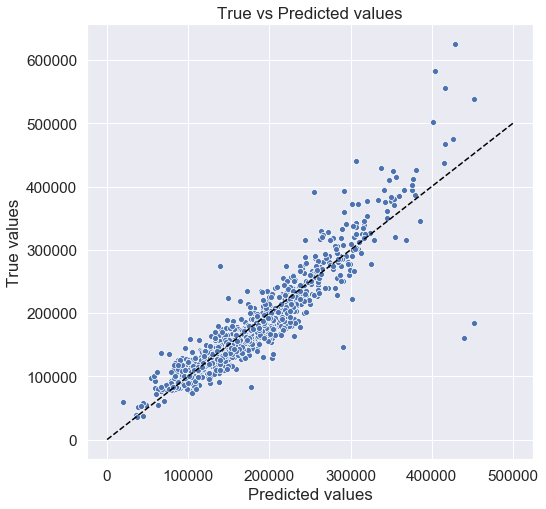

In [145]:
evaluate_preds(target_train, target_train_preds)

R2:	0.807
RMSE:	37635.849
MSE:	1416457106.67


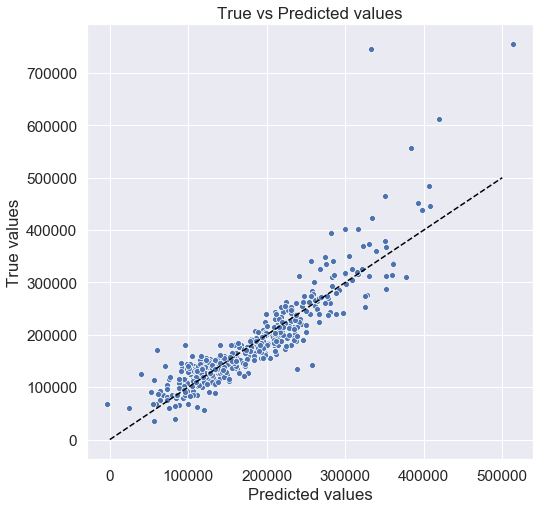

In [146]:
target_test_preds = lin_model.predict(data_test)

evaluate_preds(target_test, target_test_preds)

# Проверим, получим ли лучшее качество на более сложной модели

R2:	0.989
RMSE:	7868.115
MSE:	61907227.393


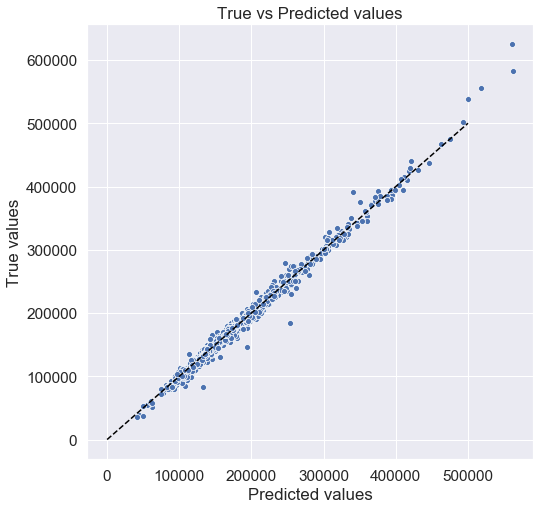

In [147]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(data_train, target_train)

target_train_preds = gb_model.predict(data_train)
evaluate_preds(target_train, target_train_preds)

R2:	0.885
RMSE:	29070.222
MSE:	845077779.434


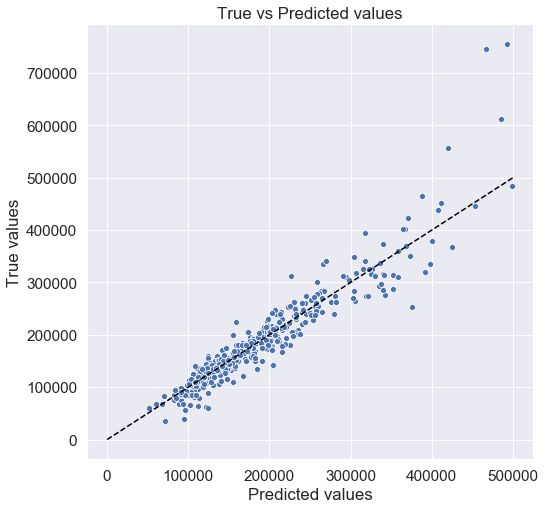

In [148]:
target_test_preds = gb_model.predict(data_test)
evaluate_preds(target_test, target_test_preds)

# Попробуем найти лучшие параметры

In [149]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=5,   
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(data_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 400], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [150]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [151]:
gs.best_score_

0.8607174899978003

In [152]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(data_train, target_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

R2:	1.0
RMSE:	1189.907
MSE:	1415878.383


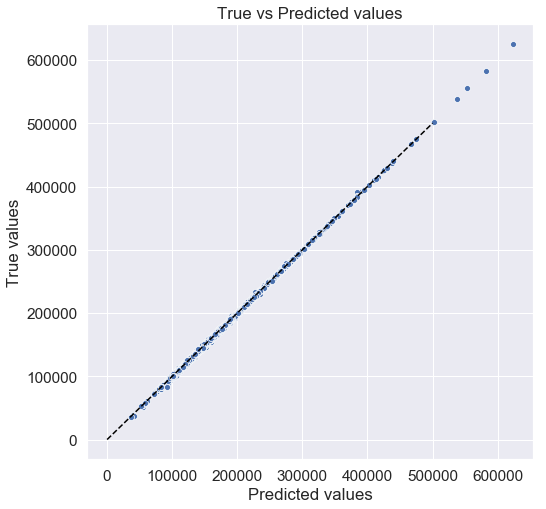

In [153]:
target_train_preds = final_model.predict(data_train)
evaluate_preds(target_train, target_train_preds)

R2:	0.888
RMSE:	28629.052
MSE:	819622594.031


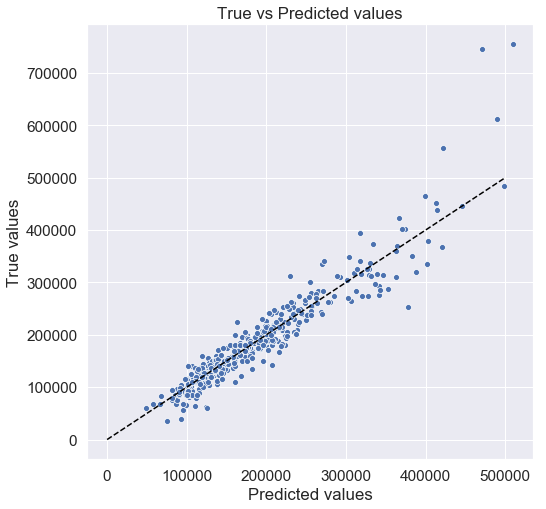

In [154]:
target_test_preds = final_model.predict(data_test)
evaluate_preds(target_test, target_test_preds, save=True)

# Построение предсказаний на test

In [155]:
data = reduce_mem_usage(pd.read_csv("test.csv"))

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 0.0%


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in longlong_scalars


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int16
MSSubClass       1459 non-null int16
MSZoning         1455 non-null category
LotFrontage      1232 non-null float32
LotArea          1459 non-null int32
Street           1459 non-null category
Alley            107 non-null category
LotShape         1459 non-null category
LandContour      1459 non-null category
Utilities        1457 non-null category
LotConfig        1459 non-null category
LandSlope        1459 non-null category
Neighborhood     1459 non-null category
Condition1       1459 non-null category
Condition2       1459 non-null category
BldgType         1459 non-null category
HouseStyle       1459 non-null category
OverallQual      1459 non-null int8
OverallCond      1459 non-null int8
YearBuilt        1459 non-null int16
YearRemodAdd     1459 non-null int16
RoofStyle        1459 non-null category
RoofMatl         1459 non-null categor

In [157]:
data.drop('Id', inplace=True, axis=1)

In [158]:
def fillna_by_mode(df):
    max_row=len(df)
    for name, values in df.iteritems():
        k=df[name].isna().sum()
        if k > (max_row // 2):
            df.drop(name, inplace=True, axis=1)
            
        elif k>0:
            mode=df[name].mode()[0]
            df[name].fillna(value=mode, inplace=True)
        
    return df

In [159]:
data_red=fillna_by_mode(data)
data_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 74 columns):
MSSubClass       1459 non-null int16
MSZoning         1459 non-null category
LotFrontage      1459 non-null float32
LotArea          1459 non-null int32
Street           1459 non-null category
LotShape         1459 non-null category
LandContour      1459 non-null category
Utilities        1459 non-null category
LotConfig        1459 non-null category
LandSlope        1459 non-null category
Neighborhood     1459 non-null category
Condition1       1459 non-null category
Condition2       1459 non-null category
BldgType         1459 non-null category
HouseStyle       1459 non-null category
OverallQual      1459 non-null int8
OverallCond      1459 non-null int8
YearBuilt        1459 non-null int16
YearRemodAdd     1459 non-null int16
RoofStyle        1459 non-null category
RoofMatl         1459 non-null category
Exterior1st      1459 non-null category
Exterior2nd      1459 non-null cat

In [160]:
for o in obj_data_names:
    data_red[o] = labelencoder.fit_transform(data_red[o])

In [161]:
final_test_preds = final_model.predict(data_red)
final_test_preds

array([395918.75551434, 284458.9172677 , 297614.62091696, ...,
       377200.03170121, 259681.91433202, 291979.51997185])

### К сожалению, я не знаю, что дальше делать с данными, что и как загружать в качестве ответа на kaggle.com